In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multi-Armed Bandit

* not utilizing `per-arm` features; simple implementation to focus on MLOPs pieces in subsequent notebooks

> **TODO**

# Step by Step Guide to Building Reinforcement Learning Applications using Vertex AI

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/tree/master/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/step_by_step_sdk_tf_agents_bandits_movie_recommendation/step_by_step_sdk_tf_agents_bandits_movie_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/master/community-content/tf_agents_bandits_movie_recommendation_with_kfp_and_vertex_sdk/step_by_step_sdk_tf_agents_bandits_movie_recommendation/step_by_step_sdk_tf_agents_bandits_movie_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview
This demo showcases the use of [TF-Agents](https://www.tensorflow.org/agents) and [Vertex AI](https://cloud.google.com/vertex-ai) in building a movie recommendation system with reinforcement learning. The demo is intended for developers interested in creating reinforcement learning applications using TensorFlow and the TF-Agents library, leveraging Vertex AI services (including custom training, custom prediction, model deployment over managed endpoints, and prediction fetching). It is recommended for developers to have familiarity with basic reinforcement learning theory, particularly the contextual bandits formulation, and the TF-Agents interface. Note that contextual bandits form a special case of RL, where the actions taken by the agent do not alter the state of the environment. “Contextual” refers to the fact that the agent chooses among a set of actions while having knowledge of the context (environment observation).

### Objective

In this notebook, you will learn how to train and deploy a TF-Agents multi-armed bandit algorithm, and how to use Vertex AI for custom training, custom serving, and endpoint deployment.

For custom training, you will implement on-policy training, in which you actively interact with a simulation environment based on MovieLens to (1) obtain environment observations, (2) choose actions using the data-collecting policy given the observations, and (3) obtain environment feedback in the form of rewards that correspond to (1)(2). These pieces of data form the training data records. This process is different from off-policy training, where you do not necessarily have training data asscociated with the actual actions outputted by the policy.

**Main goals:**
* Run a local [TF-Agents](https://www.tensorflow.org/agents) implementation
* Run the same implementation in [Vertex AI](https://cloud.google.com/vertex-ai) managed services

**we will also cover:**
1. Building custom containers for Vertex Training as well as Prediction
2. Hyperparameter tuning with Vertex AI
3. Deploying trained policies to Vertex online endpoints


This demo references code from [this TF-Agents example](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_movielens.py), [this Vertex AI SDK custom container training example](https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/sdk/AI_Platform_(Unified)_SDK_BigQuery_Custom_Container_Training.ipynb), and [this Vertex AI SDK custom container prediction example](https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/unofficial/sdk/AI_Platform_(Unified)_SDK_Custom_Container_Prediction.ipynb).

## Load notebook config

* use the prefix defined in `00-env-setup`

In [9]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

# PREFIX = 'mabv1'

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [10]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid_vertex.movielens_ds_rec_bandits_v2"
BIGQUERY_TABLE_ID        = "hybrid_vertex.movielens_ds_rec_bandits_v2.training_dataset"

REPO

### Import libraries and define constants

In [75]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# !export PYTHONWARNINGS="ignore"

In [77]:
import functools
import json
import os
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar

import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from google.cloud import aiplatform, storage

from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

# logging
import logging
logging.disable(logging.WARNING)

#python warning 
import warnings
warnings.filterwarnings("ignore")

if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

## Set Vertex Experiment

In [92]:
EXPERIMENT_NAME   = f'sxs-rl-{PREFIX}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

In [93]:
# TODO - add to 00-env-setup
DATA_PATH_KFP_DEMO = f"{DATA_PATH}/kfp_demo_data/u.data"

print(f"EXPERIMENT_NAME    : {EXPERIMENT_NAME}")
print(f"RUN_NAME           : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR    : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR            : {LOG_DIR}")
print(f"ROOT_DIR           : {ROOT_DIR}")
print(f"ARTIFACTS_DIR      : {ARTIFACTS_DIR}")
print(f"DATA_PATH_KFP_DEMO : {DATA_PATH_KFP_DEMO}")

EXPERIMENT_NAME    : sxs-rl-rec-bandits-v2
RUN_NAME           : run-20231019-041358

BASE_OUTPUT_DIR    : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358
LOG_DIR            : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/logs
ROOT_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/root
ARTIFACTS_DIR      : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/artifacts
DATA_PATH_KFP_DEMO : gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data


In [95]:
# Set hyperparameters
BATCH_SIZE       = 8      # Training and prediction batch size.
TRAINING_LOOPS   = 50     # Number of training iterations.
STEPS_PER_LOOP   = 2      # Number of driver steps per training iteration.

# Set MovieLens simulation environment parameters.
RANK_K           = 20     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 20     # Number of actions (movie items) to choose from.
PER_ARM          = False  # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001  # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0   # LinUCB exploration parameter that multiplies the confidence intervals.

## Implement and execute locally (optional)

### Define RL modules [locally]

Define a [MovieLens-specific bandits environment](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/environments/movielens_py_environment/MovieLensPyEnvironment), a [Linear UCB agent](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/agents/lin_ucb_agent) and the [regret metric](https://www.tensorflow.org/agents/api_docs/python/tf_agents/bandits/metrics/tf_metrics/RegretMetric).

In [96]:
# Define RL environment.
env = movielens_py_environment.MovieLensPyEnvironment(
    DATA_PATH_KFP_DEMO, 
    RANK_K, 
    BATCH_SIZE, 
    num_movies=NUM_ACTIONS, 
    csv_delimiter="\t"
)
environment = tf_py_environment.TFPyEnvironment(env)

# Define RL agent/algorithm.
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    tikhonov_weight=TIKHONOV_WEIGHT,
    alpha=AGENT_ALPHA,
    dtype=tf.float32,
    accepts_per_arm_features=PER_ARM
)
print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch):\n", agent.action_spec, "\n")
print("Reward Spec (for each batch):\n", environment.reward_spec(), "\n")

# Define RL metric.
optimal_reward_fn = functools.partial(
    environment_utilities.compute_optimal_reward_with_movielens_environment,
    environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)


optimal_action_fn = functools.partial(
    environment_utilities.compute_optimal_action_with_movielens_environment,
    environment=environment,
)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

metrics = [regret_metric, suboptimal_arms_metric]
print(f"metrics : {metrics}")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(20,), dtype=tf.float64, name='observation'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch):
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)) 

Reward Spec (for each batch):
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 

metrics : [<tf_agents.bandits.metrics.tf_metrics.RegretMetric object at 0x7f15c0486350>, <tf_agents.bandits.metrics.tf_metrics.SuboptimalArmsMetric object at 0x7f15c0484850>]


### Train the model [locally]

Define the training logic (on-policy training). The following function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104), but it keeps track of intermediate metric values and saves different artifacts to different locations. You can also directly invoke [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104) which also trains the policy.

In [97]:
def train(
    root_dir: str,
    log_dir: str,
    agent: TFAgent,
    environment: TFEnvironment,
    training_loops: int,
    steps_per_loop: int,
    additional_metrics: Optional[List[TFStepMetric]] = None,
    training_data_spec_transformation_fn: Optional[Callable[[T], T]] = None,
) -> Dict[str, List[float]]:
    """Performs `training_loops` iterations of training on the agent's policy.

    Uses the `environment` as the problem formulation and source of immediate
    feedback and the agent's algorithm, to perform `training-loops` iterations
    of on-policy training on the policy.
    If one or more baseline_reward_fns are provided, the regret is computed
    against each one of them. Here is example baseline_reward_fn:
    def baseline_reward_fn(observation, per_action_reward_fns):
        rewards = ... # compute reward for each arm
        optimal_action_reward = ... # take the maximum reward
        return optimal_action_reward

    Args:
        root_dir: Path to the directory where training artifacts are written.
        agent: An instance of `TFAgent`.
        environment: An instance of `TFEnvironment`.
        training_loops: An integer indicating how many training loops should be run.
        steps_per_loop: An integer indicating how many driver steps should be
           executed and presented to the trainer during each training loop.
        additional_metrics: Optional; list of metric objects to log, in addition to
          default metrics `NumberOfEpisodes`, `AverageReturnMetric`, and
          `AverageEpisodeLengthMetric`.
        training_data_spec_transformation_fn: Optional; function that transforms
          the data items before they get to the replay buffer.

    Returns:
        A dict mapping metric names (eg. "AverageReturnMetric") to a list of
        intermediate metric values over `training_loops` iterations of training.
    """
    
    # summary_writer = tf.summary.create_file_writer(root_dir)
    train_summary_writer = tf.compat.v2.summary.create_file_writer(
        log_dir, flush_millis=10 * 1000
    )
    train_summary_writer.set_as_default()
    
    
    if training_data_spec_transformation_fn is None:
        data_spec = agent.policy.trajectory_spec
    else:
        data_spec = training_data_spec_transformation_fn(
            agent.policy.trajectory_spec)
    replay_buffer = trainer._get_replay_buffer(
        data_spec
        , environment.batch_size
        ,steps_per_loop
        , 1
    )

    # `step_metric` records the number of individual rounds of bandit interaction;
    # that is, (number of trajectories) * batch_size.
    step_metric = tf_metrics.EnvironmentSteps()
    metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
    ]
    if additional_metrics:
        metrics += additional_metrics

    if isinstance(environment.reward_spec(), dict):
        metrics += [tf_metrics.AverageReturnMultiMetric(
            reward_spec=environment.reward_spec(),
            batch_size=environment.batch_size)]
    else:
        metrics += [
            tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)]

    # Store intermediate metric results, indexed by metric names.
    m_results = defaultdict(list)

    if training_data_spec_transformation_fn is not None:
        def add_batch_fn(data): return replay_buffer.add_batch(training_data_spec_transformation_fn(data)) 
        
    else:
        add_batch_fn = replay_buffer.add_batch

    observers = [add_batch_fn, step_metric] + metrics

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=steps_per_loop * environment.batch_size,
        observers=observers
    )
    
    # policy saver
    train_step_counter = tf.compat.v1.train.get_or_create_global_step()
    saver = policy_saver.PolicySaver(agent.policy, train_step=train_step_counter)

    # training_loop = trainer.get_training_loop_fn(
    training_loop = trainer._get_training_loop(        # jt TODO
        driver=driver
        , replay_buffer=replay_buffer
        , agent=agent
        , steps=steps_per_loop
        , async_steps_per_loop=1
    )

    # for _ in range(training_loops):
    for t_step in range(training_loops):
        training_loop(    # JT TODO
            train_step=t_step
            , metrics=metrics
        )
        metric_utils.log_metrics(metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step_metric.result())
            m_results[type(metric).__name__].append(metric.result().numpy())
            
        if t_step > 0 and t_step % 10 == 0:
            
            regret = m_results["RegretMetric"][-1]
            avg_return = m_results["AverageReturnMetric"][-1]
            
            step_log = f'step: {t_step} | Regret: {"%.1f" % regret}; AvgReturn: {"%.1f" % avg_return}'
            print(step_log)
                
                
    saver.save(root_dir)
    print(f"saved policy to: {root_dir}")
    
    return m_results

Train the RL policy and gather intermediate metric results

In [99]:
start_time = time.time()

m_results = train(
    root_dir=ROOT_DIR,
    log_dir=LOG_DIR,
    agent=agent,
    environment=environment,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"runtime_mins: {runtime_mins}")

step: 10 | Regret: 3.4; AvgReturn: 1.1
step: 20 | Regret: 3.9; AvgReturn: 0.4
step: 30 | Regret: 1.6; AvgReturn: 2.5
step: 40 | Regret: 1.4; AvgReturn: 2.8
saved policy to: gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/root
runtime_mins: 1


In [100]:
m_results['AverageReturnMetric'][-1]

2.6

### Evaluate RL metrics [locally]

You can visualize how the regret and average return metrics evolve over training steps.

In [101]:
def plot(m_results, metric_name):
    plt.plot(m_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

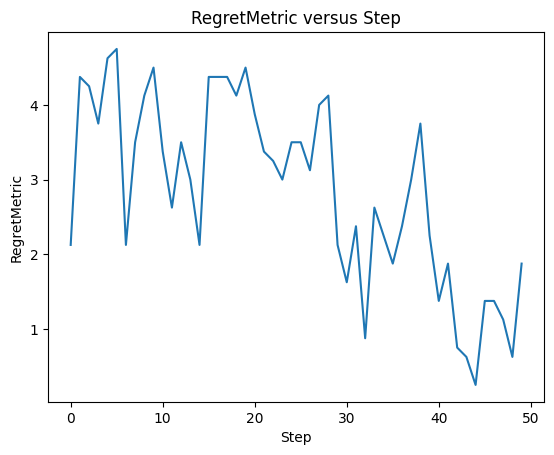

In [102]:
plot(m_results, "RegretMetric")

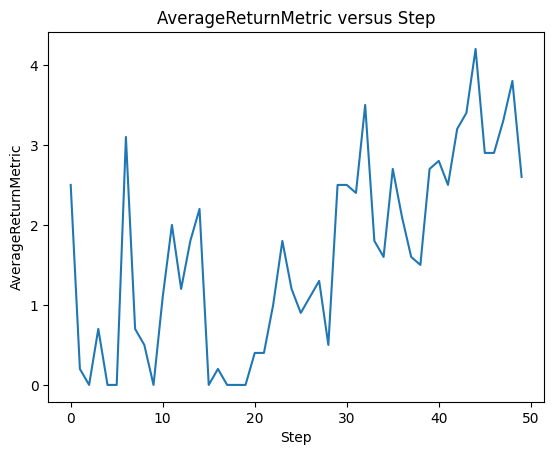

In [103]:
plot(m_results, "AverageReturnMetric")

In [104]:
LOG_DIR

'gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/logs'

In [106]:
# %load_ext tensorboard
%reload_ext tensorboard

In [271]:
# %tensorboard --logdir=$LOG_DIR

## Execute in Vertex AI Training

This section consists of the following steps:
1.   Run unit tests on `policy_util` and `task` modules
2.   Create hyperparameter tuning and training custom container
3.   Submit hyperparameter tuning job [optional]
4.   Create custom prediction container
5.   Submit custom container training job
6.   Deploy trained model to Endpoint
7.   Predict on the Endpoint

### Run unit tests on `policy_util` and `task` modules

Run unit tests on the modules in `src/training/`.

In [123]:
data_config = f'''
PREFIX             = \"{PREFIX}\"
BUCKET_NAME        = \"{BUCKET_NAME}\"
EXPERIMENT_NAME    = \"{EXPERIMENT_NAME}\"
RUN_NAME           = \"{RUN_NAME}\"
BASE_OUTPUT_DIR    = \"{BASE_OUTPUT_DIR}\"
LOG_DIR            = \"{LOG_DIR}\"
ROOT_DIR           = \"{ROOT_DIR}\"
ARTIFACTS_DIR      = \"{ARTIFACTS_DIR}\"
DATA_PATH_KFP_DEMO = \"{DATA_PATH_KFP_DEMO}\"
'''
print(data_config)


PREFIX             = "rec-bandits-v2"
BUCKET_NAME        = "rec-bandits-v2-hybrid-vertex-bucket"
EXPERIMENT_NAME    = "sxs-rl-rec-bandits-v2"
RUN_NAME           = "run-20231019-041358"
BASE_OUTPUT_DIR    = "gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358"
LOG_DIR            = "gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/logs"
ROOT_DIR           = "gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/root"
ARTIFACTS_DIR      = "gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/artifacts"
DATA_PATH_KFP_DEMO = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"



In [124]:
with open(f'src/utils/data_config.py', 'w') as f:
    f.write(data_config)

### clear device

In [128]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [129]:
import gc
gc.collect()

14

### Run commands in-notebook or copy to terminal window (preferred)

In [131]:
# ! python3 -m unittest src/tests/test_policy_util.py

In [113]:
# ! python3 -m unittest src/tests/test_task.py

### Create custom container for Vertex AI, and account for hyperparameter tuning

Create a custom container that can be used for both hyperparameter tuning and training. The associated source code is in `src/training/`. This serves as the inner script of the custom container.
As before, the training function is the same as [trainer.train](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/bandits/agents/examples/v2/trainer.py#L104), but it keeps track of intermediate metric values, supports hyperparameter tuning, and (for training) saves artifacts to different locations. The training logic for hyperparameter tuning and training is the same.

#### Execute hyperparameter tuning:
- The code does not save model artifacts. It takes in command-line arguments as hyperparameter values from the Vertex AI Hyperparameter Tuning service, and reports training result metric to Vertex AI at each trial using cloudml-hypertune.
- Note that if you decide to save model artifacts, saving them to the same directory may cause overwriting errors if you use parallel trials in the hyperparameter tuning job. The recommended approach is to save each trial's artifacts to a different sub-directory. This would also allow you to recover all the artifacts from different trials and can potentially save you from re-training.
- Read more about hyperparameter tuning for custom containers [here](https://cloud.google.com/vertex-ai/docs/training/containers-overview#hyperparameter_tuning_with_custom_containers); read about hyperparameter tuning support [here](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview).

#### Execute training:
- The code saves model artifacts to `os.environ["AIP_MODEL_DIR"]` in addition to `ARTIFACTS_DIR`, as required [here](https://github.com/googleapis/python-aiplatform/blob/v0.8.0/google/cloud/aiplatform/training_jobs.py#L2202).
- If you want to make changes to the function, make sure to still save the trained policy as a SavedModel to clean directories, and avoid saving checkpoints and other artifacts, so that deploying the model to endpoints works.

In [150]:
print(f"IMAGE_NAME_04 : {IMAGE_NAME_04}")
print(f"IMAGE_URI_04  : {IMAGE_URI_04}")
print(f"DOCKERNAME_04 : {DOCKERNAME_04}")

TRAIN_MAB_IMAGE_NAME : train_hpt_mab_e2e
TRAIN_MAB_IMAGE_URI  : gcr.io/hybrid-vertex/train_hpt_mab_e2e
DOCKERNAME_MAB       : Dockerfile_train_mab_e2e


#### Create a Cloud Build YAML file

Use [Kaniko](https://github.com/GoogleContainerTools/kaniko) to build the hyperparameter-tuning/training container. You can apply caching and specify the build machine type. Alternatively, you can also use Docker build.

In [151]:
%%writefile cloudbuild.yaml

steps:
- name: 'gcr.io/cloud-builders/docker'
  args: ['build', '-t', '$_IMAGE_URI', '$_FILE_LOCATION', '-f', '$_FILE_LOCATION/$_DOCKERNAME']
images:
- '$_IMAGE_URI'

Overwriting cloudbuild.yaml


#### Write a Dockerfile

- Use the [cloudml-hypertune](https://github.com/GoogleCloudPlatform/cloudml-hypertune) Python package to report training metrics to Vertex AI for hyperparameter tuning.
- Use the Google [Cloud Storage client library](https://cloud.google.com/storage/docs/reference/libraries) to read the best hyperparameters learned from a previous hyperarameter tuning job during training.

In [160]:
gpu_profiling = True # True | False

print(f"gpu_profiling : {gpu_profiling}")

gpu_profiling : True


In [161]:
if gpu_profiling:
    # TRAIN_BASE_IMAGE = 'tensorflow/tensorflow:2.13.0-gpu'
    TRAIN_BASE_IMAGE = 'gcr.io/deeplearning-platform-release/tf2-gpu.2-13.py310'
    NVTOP_RUN = 'RUN apt update && apt -y install nvtop'
    # NVTOP_RUN = 'RUN apt-get update && apt-get -y install nvtop'
else:
    TRAIN_BASE_IMAGE = 'python:3.10'
    NVTOP_RUN = None
    
RUN_EXPORT = "RUN export PYTHONPATH=${PYTHONPATH}:${APP_HOME}/"
    
print(f"TRAIN_BASE_IMAGE : {TRAIN_BASE_IMAGE}")
print(f"NVTOP_RUN        : {NVTOP_RUN}")
print(f"RUN_EXPORT       : {RUN_EXPORT}")

TRAIN_BASE_IMAGE : gcr.io/deeplearning-platform-release/tf2-gpu.2-13.py310
NVTOP_RUN        : RUN apt update && apt -y install nvtop
RUN_EXPORT       : RUN export PYTHONPATH=${PYTHONPATH}:${APP_HOME}/


In [162]:
dockerfile = f'''
# Specifies base image and tag.
# FROM gcr.io/google-appengine/python
FROM {TRAIN_BASE_IMAGE}

ENV PYTHONUNBUFFERED True
WORKDIR /root

RUN pip install --upgrade pip

RUN pip install cloudml-hypertune==0.1.0.dev6
RUN pip install google-cloud-storage==1.39.0
RUN pip install tensorflow==2.13.0
RUN pip install tensorboard-plugin-profile==2.13.1
RUN pip install tf-agents==0.17.0
RUN pip install matplotlib==3.8.0
RUN pip install urllib3==1.26.6

{NVTOP_RUN}

# Copies training code to the Docker image.
COPY src/training /root/src/training

{RUN_EXPORT}

# Sets up the entry point to invoke the task.
ENTRYPOINT ["python3", "-m", "src.training.task"]
'''
print(dockerfile)


# Specifies base image and tag.
# FROM gcr.io/google-appengine/python
FROM gcr.io/deeplearning-platform-release/tf2-gpu.2-13.py310

ENV PYTHONUNBUFFERED True
WORKDIR /root

RUN pip install --upgrade pip

RUN pip install cloudml-hypertune==0.1.0.dev6
RUN pip install google-cloud-storage==1.39.0
RUN pip install tensorflow==2.13.0
RUN pip install tensorboard-plugin-profile==2.13.1
RUN pip install tf-agents==0.17.0
RUN pip install matplotlib==3.8.0
RUN pip install urllib3==1.26.6

RUN apt update && apt -y install nvtop

# Copies training code to the Docker image.
COPY src/training /root/src/training

RUN export PYTHONPATH=${PYTHONPATH}:${APP_HOME}/

# Sets up the entry point to invoke the task.
ENTRYPOINT ["python3", "-m", "src.training.task"]



In [163]:
with open(f'{DOCKERNAME_MAB}', 'w') as f:
    f.write(dockerfile)

### Files that will be included in Cloud Build image
* to adjust this see the gcloudignore section at the end of `00-env-setup.ipynb` notebook

In [270]:
# check eligble files
!gcloud meta list-files-for-upload

requirements.txt
instances.json
Dockerfile_predict_mab_e2e
Dockerfile_train_mab_e2e
cloudbuild.yaml
src/prediction/prestart.sh
src/prediction/main.py
src/training/policy_util.py
src/training/task.py
src/utils/data_config.py
hptuning/result.json


#### Build the custom container with Cloud Build

In [165]:
# image definitions for training
MACHINE_TYPE          ='e2-highcpu-32'
FILE_LOCATION         = "." # './src'

DOCKERNAME            = DOCKERNAME_04
IMAGE_URI             = IMAGE_URI_04

print(f"DOCKERNAME    : {DOCKERNAME}")
print(f"IMAGE_URI     : {IMAGE_URI}")
print(f"FILE_LOCATION : {FILE_LOCATION}")
print(f"MACHINE_TYPE  : {MACHINE_TYPE}")

DOCKERNAME    : Dockerfile_train_mab_e2e
IMAGE_URI     : gcr.io/hybrid-vertex/train_hpt_mab_e2e
FILE_LOCATION : .
MACHINE_TYPE  : e2-highcpu-32


Copy printed command below && run in a **notebook terminal** to continue working in-notebook while image builds

In [ ]:
CLOUD_BUILD_CMD = f'''gcloud builds submit --config ./cloudbuild.yaml \
--substitutions _DOCKERNAME={DOCKERNAME},_IMAGE_URI={IMAGE_URI},_FILE_LOCATION={FILE_LOCATION} \
--timeout=2h \
--machine-type={MACHINE_TYPE} \
--quiet
'''
print(CLOUD_BUILD_CMD)

In [214]:
# ! gcloud builds submit --config ./cloudbuild.yaml \
#     --substitutions _DOCKERNAME=$DOCKERNAME,_IMAGE_URI=$IMAGE_URI,_FILE_LOCATION=$FILE_LOCATION \
#     --timeout=2h \
#     --machine-type=$MACHINE_TYPE \
#     --quiet

### Submit hyperparameter tuning job [optional]

- Submit a hyperparameter training job with the custom container. Read more details for using Python packages as an alternative to using custom containers in the example shown [here](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning#create).
- Define the hyperparameter(s), max trial count, parallel trial count, parameter search algorithm, machine spec, accelerators, worker pool, etc.

> **TODO:** add Tensorboard resource to hpt job

In [206]:
RUN_HYPERPARAMETER_TUNING       = True   # Execute hyperparameter tuning instead of regular training.
TRAIN_WITH_BEST_HYPERPARAMETERS = False  # Do not train. 

HPTUNING_RESULT_DIR                = "hptuning"
HPTUNING_RESULT_FILE               = "result.json"
HPTUNING_RESULT_PATH               = f"{EXPERIMENT_NAME}/{RUN_NAME}/{HPTUNING_RESULT_DIR}/{HPTUNING_RESULT_FILE}"
HPTUNING_RESULT_URI                = f"{BUCKET_URI}/{HPTUNING_RESULT_PATH}"

print(f"HPTUNING_RESULT_DIR  : {HPTUNING_RESULT_DIR}")
print(f"HPTUNING_RESULT_FILE : {HPTUNING_RESULT_FILE}")
print(f"HPTUNING_RESULT_PATH : {HPTUNING_RESULT_PATH}")
print(f"HPTUNING_RESULT_URI  : {HPTUNING_RESULT_URI}")

HPTUNING_RESULT_DIR  : hptuning
HPTUNING_RESULT_FILE : result.json
HPTUNING_RESULT_PATH : sxs-rl-rec-bandits-v2/run-20231019-041358/hptuning/result.json
HPTUNING_RESULT_URI  : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/hptuning/result.json


In [168]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [169]:
def create_hyperparameter_tuning_job_sample(
    project: str,
    display_name: str,
    image_uri: str,
    args: List[str],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com"
) -> None:
    """Creates a hyperparameter tuning job using a custom container.

    Args:
        project: GCP project ID.
        display_name: GCP console display name for the hyperparameter tuning job in
            Vertex AI.
        image_uri: URI to the hyperparameter tuning container image in Container
            Registry.
        args: Arguments passed to the container.
        location: Service location.
        api_endpoint: API endpoint, eg. `<location>-aiplatform.googleapis.com`.

    Returns:
        A string of the hyperparameter tuning job ID.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)

    # study_spec
    # Metric based on which to evaluate which combination of hyperparameter(s) to choose
    metric = {
        "metric_id": "final_average_return",  # Metric you report to Vertex AI.
        "goal": aiplatform.gapic.StudySpec.MetricSpec.GoalType.MAXIMIZE,
    }

    # Hyperparameter(s) to tune
    training_loops = {
        "parameter_id": "training-loops",
        "discrete_value_spec": {"values": [4, 16]},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
    }
    steps_per_loop = {
        "parameter_id": "steps-per-loop",
        "discrete_value_spec": {"values": [1, 2]},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
    }

    # trial_job_spec
    machine_spec = {
        "machine_type": "n1-highcpu-16",
        "accelerator_type": aiplatform.gapic.AcceleratorType.ACCELERATOR_TYPE_UNSPECIFIED,
        "accelerator_count": None,
    }
    worker_pool_spec = {
        "machine_spec": machine_spec,
        "replica_count": 1,
        "container_spec": {
            "image_uri": image_uri,
            "args": args,
        },
    }

    # hyperparameter_tuning_job
    hyperparameter_tuning_job = {
        "display_name": display_name,
        "max_trial_count": 4,
        "parallel_trial_count": 2,
        "study_spec": {
            "metrics": [metric],
            "parameters": [training_loops, steps_per_loop],
            "algorithm": aiplatform.gapic.StudySpec.Algorithm.RANDOM_SEARCH,
        },
        "trial_job_spec": {"worker_pool_specs": [worker_pool_spec]},
    }
    parent = f"projects/{project}/locations/{location}"

    # Create job
    response = client.create_hyperparameter_tuning_job(
        parent=parent,
        hyperparameter_tuning_job=hyperparameter_tuning_job)
    job_id = response.name.split("/")[-1]
    print("Job ID:", job_id)
    print("Job config:", response)

    return job_id

In [170]:
print(f"TRAIN_MAB_IMAGE_NAME : {TRAIN_MAB_IMAGE_NAME}")
print(f"TRAIN_MAB_IMAGE_URI  : {TRAIN_MAB_IMAGE_URI}")
print(f"DOCKERNAME_MAB       : {DOCKERNAME_MAB}")

TRAIN_MAB_IMAGE_NAME : train_hpt_mab_e2e
TRAIN_MAB_IMAGE_URI  : gcr.io/hybrid-vertex/train_hpt_mab_e2e
DOCKERNAME_MAB       : Dockerfile_train_mab_e2e


In [172]:
args = [
    f"--data-path={DATA_PATH_KFP_DEMO}",
    f"--batch-size={BATCH_SIZE}",
    f"--rank-k={RANK_K}",
    f"--num-actions={NUM_ACTIONS}",
    f"--tikhonov-weight={TIKHONOV_WEIGHT}",
    f"--agent-alpha={AGENT_ALPHA}",
]
if RUN_HYPERPARAMETER_TUNING:
    args.append("--run-hyperparameter-tuning")
elif TRAIN_WITH_BEST_HYPERPARAMETERS:
    args.append("--train-with-best-hyperparameters")
    
pprint(args)

['--data-path=gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data',
 '--batch-size=8',
 '--rank-k=20',
 '--num-actions=20',
 '--tikhonov-weight=0.001',
 '--agent-alpha=10.0',
 '--run-hyperparameter-tuning']


In [173]:
job_id = create_hyperparameter_tuning_job_sample(
    project=PROJECT_ID,
    display_name="mab-hpt-tuning-job",
    image_uri=f"gcr.io/{PROJECT_ID}/{TRAIN_MAB_IMAGE_NAME}:latest",
    args=args,
    location=REGION,
    api_endpoint=f"{REGION}-aiplatform.googleapis.com"
)

Job ID: 3763149808160735232
Job config: name: "projects/934903580331/locations/us-central1/hyperparameterTuningJobs/3763149808160735232"
display_name: "mab-hpt-tuning-job"
study_spec {
  metrics {
    metric_id: "final_average_return"
    goal: MAXIMIZE
  }
  parameters {
    parameter_id: "training-loops"
    discrete_value_spec {
      values: 4.0
      values: 16.0
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "steps-per-loop"
    discrete_value_spec {
      values: 1.0
      values: 2.0
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  algorithm: RANDOM_SEARCH
}
max_trial_count: 4
parallel_trial_count: 2
trial_job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-highcpu-16"
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    container_spec {
      image_uri: "gcr.io/hybrid-vertex/train_hpt_mab_e2e:latest"
      args: "--data-path=gs://rec-bandits-v2-hybrid-vertex-bucket/da

It will take ~20 minutes to complete.

#### Check hyperparameter tuning job status

- Read more about managing jobs [here](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning#manage).

In [177]:
def get_hyperparameter_tuning_job_sample(
    project: str,
    hyperparameter_tuning_job_id: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
) -> aiplatform.HyperparameterTuningJob:
    """Gets the current status of a hyperparameter tuning job.

    Args:
        project: GCP project ID.
        hyperparameter_tuning_job_id: Hyperparameter tuning job ID.
        location: Service location.
        api_endpoint: API endpoint, eg. `<location>-aiplatform.googleapis.com`.

    Returns:
        Details of the hyperparameter tuning job, such as its running status,
        results of its trials, etc.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    name = client.hyperparameter_tuning_job_path(
        project=project,
        location=location,
        hyperparameter_tuning_job=hyperparameter_tuning_job_id)
    response = client.get_hyperparameter_tuning_job(name=name)
    return response

In [178]:
import time

trials = None
while True:
    response = get_hyperparameter_tuning_job_sample(
        project=PROJECT_ID,
        hyperparameter_tuning_job_id=job_id,
        location=REGION,
        api_endpoint=f"{REGION}-aiplatform.googleapis.com")
    if response.state.name == 'JOB_STATE_SUCCEEDED':
        print("Job succeeded.\nJob Time:", response.update_time - response.create_time)
        trials = response.trials
        print("Trials:", trials)
        break
    elif response.state.name == "JOB_STATE_FAILED":
        print("Job failed.")
        break
    elif response.state.name == "JOB_STATE_CANCELLED":
        print("Job cancelled.")
        break
    else:
        print(f"Current job status: {response.state.name}.")
    time.sleep(60)

Job succeeded.
Job Time: 0:22:08.361312
Trials: [id: "1"
state: SUCCEEDED
parameters {
  parameter_id: "steps-per-loop"
  value {
    number_value: 2.0
  }
}
parameters {
  parameter_id: "training-loops"
  value {
    number_value: 4.0
  }
}
final_measurement {
  step_count: 1
  metrics {
    metric_id: "final_average_return"
    value: 0.30000001192092896
  }
}
start_time {
  seconds: 1697695805
  nanos: 515489343
}
end_time {
  seconds: 1697696088
}
, id: "2"
state: SUCCEEDED
parameters {
  parameter_id: "steps-per-loop"
  value {
    number_value: 2.0
  }
}
parameters {
  parameter_id: "training-loops"
  value {
    number_value: 16.0
  }
}
final_measurement {
  step_count: 1
  metrics {
    metric_id: "final_average_return"
    value: 0.699999988079071
  }
}
start_time {
  seconds: 1697695805
  nanos: 515696004
}
end_time {
  seconds: 1697696091
}
, id: "3"
state: SUCCEEDED
parameters {
  parameter_id: "steps-per-loop"
  value {
    number_value: 2.0
  }
}
parameters {
  parameter_

#### Find the best combination(s) hyperparameter(s) for each metric

In [196]:
if trials:
    # Dict mapping from metric names to the best metric values seen so far
    best_objective_values = dict.fromkeys(
        [metric.metric_id for metric in trials[0].final_measurement.metrics],
        -np.inf)
    # Dict mapping from metric names to a list of the best combination(s) of
    # hyperparameter(s). Each combination is a dict mapping from hyperparameter
    # names to their values.
    best_params = defaultdict(list)
    for trial in trials:
        # `final_measurement` and `parameters` are `RepeatedComposite` objects.
        # Reference the structure above to extract the value of your interest.
        for metric in trial.final_measurement.metrics:
            params = {
                param.parameter_id: param.value.number_value for param in trial.parameters
            }
            
            if metric.value > best_objective_values[metric.metric_id]:
                best_params[metric.metric_id] = [params]
            elif metric.value == best_objective_values[metric.metric_id]:
                best_params[param.parameter_id].append(params)  # Handle cases where multiple hyperparameter values lead to the same performance.
    print("Best hyperparameter value(s):")
    for metric, params in best_params.items():
        print(f"Metric={metric}: {sorted(params)}")
else:
    print("No hyperparameter tuning job trials found.")

Best hyperparameter value(s):
Metric=final_average_return: [{'steps-per-loop': 2.0, 'training-loops': 4.0}]


In [207]:
BEST_PARAM_DICT = best_params["final_average_return"][0]
print(f"BEST_PARAM_DICT       : {BEST_PARAM_DICT}")

LOCAL_HPT_RESULT_DIR = "hptuning/"
LOCAL_HPT_RESULT_PATH = os.path.join(LOCAL_HPT_RESULT_DIR, "result.json")

print(f"LOCAL_HPT_RESULT_PATH : {LOCAL_HPT_RESULT_PATH}")

! rm -rf $LOCAL_HPT_RESULT_DIR
! mkdir $LOCAL_HPT_RESULT_DIR

BEST_PARAM_DICT       : {'steps-per-loop': 2.0, 'training-loops': 4.0}
LOCAL_HPT_RESULT_PATH : hptuning/result.json


#### Convert a combination of best hyperparameter(s) for a metric of interest to JSON

In [208]:
with open(LOCAL_HPT_RESULT_PATH, "w") as f:
    json_dumps_str = json.dumps(BEST_PARAM_DICT)
    f.write(json_dumps_str)

#### Upload the best hyperparameter(s) to GCS for use in training

In [211]:
!gsutil -q cp $LOCAL_HPT_RESULT_PATH $HPTUNING_RESULT_URI

Copying file://hptuning/result.json [Content-Type=application/json]...
/ [1 files][   46.0 B/   46.0 B]                                                
Operation completed over 1 objects/46.0 B.                                       


## Create custom prediction container

As with training, create a custom prediction container. This container handles the TF-Agents specific logic that is different from a regular TensorFlow Model. Specifically, it finds the predicted action using a trained policy. The associated source code is in `src/prediction/`.
See other options for Vertex AI predictions [here](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions).

#### Serve predictions:
- Use [`tensorflow.saved_model.load`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/policies/PolicySaver#usage), instead of [`tf_agents.policies.policy_loader.load`](https://github.com/tensorflow/agents/blob/r0.8.0/tf_agents/policies/policy_loader.py#L26), to load the trained policy, because the latter produces an object of type [`SavedModelPyTFEagerPolicy`](https://github.com/tensorflow/agents/blob/402b8aa81ca1b578ec1f687725d4ccb4115386d2/tf_agents/policies/py_tf_eager_policy.py#L137) whose `action()` is not compatible for use here.
- Note that prediction requests contain only observation data but not reward. This is because: The prediction task is a standalone request that doesn't require prior knowledge of the system state. Meanwhile, end users only know what they observe at the moment. Reward is a piece of information that comes after the action has been made, so the end users would not have knowledge of said reward. In handling prediction requests, you create a [`TimeStep`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/TimeStep) object (consisting of `observation`, `reward`, `discount`, `step_type`) using the [`restart()`](https://www.tensorflow.org/agents/api_docs/python/tf_agents/trajectories/restart) function which takes in an `observation`. This function creates the *first* TimeStep in a trajectory of steps, where reward is 0, discount is 1 and step_type is marked as the first timestep. In other words, each prediction request forms the first `TimeStep` in a brand new trajectory.
- For the prediction response, avoid using NumPy-typed values; instead, convert them to native Python values using methods such as [`tolist()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tolist.html) as opposed to `list()`.
- There exists a prestart script in `src/prediction`. FastAPI executes this script before starting up the server. The `PORT` environment variable is set to equal `AIP_HTTP_PORT` in order to run FastAPI on the same port expected by Vertex AI.

In [212]:
print(f"DOCKERNAME_04_pred   : {DOCKERNAME_04_pred}")
print(f"IMAGE_NAME_04_pred   : {IMAGE_NAME_04_pred}")
print(f"IMAGE_URI_04_pred    : {IMAGE_URI_04_pred}")

PRED_MAB_IMAGE_NAME : mab_custom_prediction_rec_bandits_v2
PRED_MAB_IMAGE_URI  : gcr.io/hybrid-vertex/mab_custom_prediction_rec_bandits_v2
DOCKERNAME_MAB_PRED : Dockerfile_predict_mab_e2e
ARTIFACTS_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/artifacts


#### Create a Cloud Build YAML file

Use [Kaniko](https://github.com/GoogleContainerTools/kaniko) to build the custom prediction container.

In [114]:
CLOUD_BUILD_CONFIG = f'''
steps:
- name: 'gcr.io/cloud-builders/docker'
  args: ['build', '-t', '$_IMAGE_URI', '$_FILE_LOCATION', '-f', '$_FILE_LOCATION/$_DOCKERNAME']
  env: ['AIP_STORAGE_URI={ARTIFACTS_DIR}']
images:
- '$_IMAGE_URI'
'''
print(CLOUD_BUILD_CONFIG)

In [ ]:
CLOUD_BUILD_YAML = 'cloudbuild.yaml'

with open(f'{CLOUD_BUILD_YAML}', 'w') as f:
    f.write(CLOUD_BUILD_CONFIG)

#### Define dependencies

- Note that the dependencies should be compatiable with one another

In [115]:
# %%writefile requirements.txt
# numpy
# six
# typing-extensions~=4.6.3
# pillow
# tf-agents==0.17.0
# tensorflow==2.13.0

Overwriting requirements.txt


#### Write a Dockerfile

Note: leave the server directory `app`.

In [116]:
dockerfile = f'''
FROM tiangolo/uvicorn-gunicorn-fastapi:python3.10

COPY src/prediction /app
COPY requirements.txt /app/requirements.txt

RUN pip3 install -r /app/requirements.txt
'''
print(dockerfile)

Overwriting Dockerfile


In [ ]:
with open(f'{DOCKERNAME_MAB_PRED}', 'w') as f:
    f.write(dockerfile)

#### Build the prediction container with Cloud Build

> run command in terminal

In [ ]:
# image definitions for training
MACHINE_TYPE            ='e2-highcpu-32'
FILE_LOCATION           = "." # './src'

DOCKERNAME            = DOCKERNAME_04_pred
IMAGE_URI             = IMAGE_URI_04_pred

print(f"DOCKERNAME    : {DOCKERNAME}")
print(f"IMAGE_URI     : {IMAGE_URI}")
print(f"FILE_LOCATION : {FILE_LOCATION}")
print(f"MACHINE_TYPE  : {MACHINE_TYPE}")

In [ ]:
CLOUD_BUILD_CMD = f'''gcloud builds submit --config ./{CLOUD_BUILD_YAML} \
--substitutions _DOCKERNAME={DOCKERNAME},_IMAGE_URI={IMAGE_URI},_FILE_LOCATION={FILE_LOCATION} \
--timeout=2h \
--machine-type={MACHINE_TYPE} \
--quiet
'''
print(CLOUD_BUILD_CMD)

In [175]:
# ! gcloud builds submit --config cloudbuild.yaml

### Submit custom container training job

- Note again that the bucket must be in the same regional location as the service location and it should not be multi-regional.
- Read more of CustomContainerTrainingJob's source code [here](https://github.com/googleapis/python-aiplatform/blob/v0.8.0/google/cloud/aiplatform/training_jobs.py#L2153).
- Like with local execution, you can use TensorBoard Profiler to track the training process and resources, and visualize the corresponding artifacts using the command: `%tensorboard --logdir $LOG_DIR`.

In [216]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [217]:
RUN_HYPERPARAMETER_TUNING       = False  # Execute regular training instead of hyperparameter tuning.
TRAIN_WITH_BEST_HYPERPARAMETERS = True   #{type:"bool"} Whether to use learned hyperparameters in training.

In [220]:
args = [
    f"--artifacts-dir={ARTIFACTS_DIR}",
    f"--profiler-dir={LOG_DIR}",
    f"--data-path={DATA_PATH_KFP_DEMO}",
    f"--batch-size={BATCH_SIZE}",
    f"--rank-k={RANK_K}",
    f"--num-actions={NUM_ACTIONS}",
    f"--tikhonov-weight={TIKHONOV_WEIGHT}",
    f"--agent-alpha={AGENT_ALPHA}",
]
if RUN_HYPERPARAMETER_TUNING:
    args.append("--run-hyperparameter-tuning")
elif TRAIN_WITH_BEST_HYPERPARAMETERS:
    args.append("--train-with-best-hyperparameters")
    args.append(f"--best-hyperparameters-bucket={BUCKET_NAME}")
    args.append(f"--best-hyperparameters-path={HPTUNING_RESULT_PATH}")
    
pprint(args)

['--artifacts-dir=gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/artifacts',
 '--profiler-dir=gs://rec-bandits-v2-hybrid-vertex-bucket/sxs-rl-rec-bandits-v2/run-20231019-041358/logs',
 '--data-path=gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data',
 '--batch-size=8',
 '--rank-k=20',
 '--num-actions=20',
 '--tikhonov-weight=0.001',
 '--agent-alpha=10.0',
 '--train-with-best-hyperparameters',
 '--best-hyperparameters-bucket=rec-bandits-v2-hybrid-vertex-bucket',
 '--best-hyperparameters-path=sxs-rl-rec-bandits-v2/run-20231019-041358/hptuning/result.json']


In [224]:
TRAIN_CMD = ["python3", "-m", "src.training.task"] + args

job = aiplatform.CustomContainerTrainingJob(
    display_name="tuned-mab-training",
    container_uri=f"{TRAIN_MAB_IMAGE_URI}:latest",
    command=TRAIN_CMD,
    model_serving_container_image_uri=f"{PRED_MAB_IMAGE_URI}:latest",
    model_serving_container_predict_route="/predict",
    model_serving_container_health_route="/health"
)

print("Training Spec:", job._managed_model)

Training Spec: container_spec {
  image_uri: "gcr.io/hybrid-vertex/mab_custom_prediction_rec_bandits_v2:latest"
  predict_route: "/predict"
  health_route: "/health"
}



In [225]:
model = job.run(
    model_display_name=f"movielens-mab-{PREFIX}",
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="ACCELERATOR_TYPE_UNSPECIFIED",
    accelerator_count=0,
    sync=False
)

In [228]:
print("Model display name:", model.display_name)
print("Model ID:", model.name)

Model display name: movielens-mab-rec-bandits-v2
Model ID: 8072656152573247488


### Deploy trained model to an Endpoint

* see `model.deploy()` [source code](https://github.com/googleapis/python-aiplatform/blob/main/google/cloud/aiplatform/models.py#L748)

In [229]:
endpoint = model.deploy(
    sync=False,
    machine_type="n1-standard-4"
)

In [260]:
ENDPOINT_ID = endpoint.name
ENDPOINT_DISPLAY_NAME = endpoint.display_name

print("Endpoint display name:", ENDPOINT_DISPLAY_NAME)
print("Endpoint ID:", ENDPOINT_ID)

Endpoint display name: movielens-mab-rec-bandits-v2_endpoint
Endpoint ID: 7494361414874693632


## Predict on the Endpoint
- Put prediction input(s) into a list named `instances`. The observation should of dimension (BATCH_SIZE, RANK_K). Read more about the MovieLens simulation environment observation [here](https://github.com/tensorflow/agents/blob/v0.8.0/tf_agents/bandits/environments/movielens_py_environment.py#L32-L138).
- Read more about the endpoint prediction API [here](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict).


*Note: if experiencing the error below, check `protobuf` version:*

```python
AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'WhichOneof'AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'WhichOneof'
```

Common packages to update:

```
pip install -U protobuf 
pip install -U google-api-core
pip install -U google-cloud-core
pip install -U google-auth
```

In [259]:
endpoint.predict(
    instances=[
        {"observation": [list(np.ones(20)) for _ in range(8)]},
    ]
)

### predict request with `gcloud`

In [265]:
TEST_INSTANCE = {"observation": [list(np.ones(20)) for _ in range(8)]}

TEST_TO_JSON = {
    "instances": [TEST_INSTANCE]
}

with open('instances.json', "w") as f:
    json_dumps_str = json.dumps(TEST_TO_JSON)
    f.write(json_dumps_str)

In [266]:
!gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=instances.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'PolicyStep 0': [4, 4, 4, 4, 4, 4, 4, 4]}]


# Summary

### What exactly is the purpose of the MovieLens simulation environment?

The MovieLens environment *simulates* real-world environment containing users and their respective preferences. Internally, the MovieLens simulation environment takes the user-by-movie-item rating matrix and performs a `RANK_K` matrix factorization on the rating matrix, in order to address the sparsity of the matrix. After this construction step, the environment can generate user vectors of dimension `RANK_K` to represent users in the simulation environment, and is able to determine the approximate reward for any user and movie item pair. In RL's language, user vectors are observations, recommended movie items are actions, and approximate ratings are rewards. This environment therefore defines the RL problem at hand: how to recommend movies that maximize user ratings, in a simulated world of users with their respective preferences defined by the MovieLens dataset, while having zero knowledge of the internal mechanism of the environment.

Note here the user vectors may not be in the same dimension as in the original rating matrix, and the approximate ratings (to address the sparsity of rating data) may not equal the original ratings. The individual entries in the user vectors do not correspond to real-world meanings, such as user age, etc.. In prediction requests, the observations are user vectors that lie in the same space as those generated by the MovieLens simulation environment. In other words, they represent users in the same way as the user vectors/observations generated by the MovieLens environment.

The reason why this demo adopts the MovieLens environment is to base itself on a public dataset without needing to communicate with the real world; such communication adds overhead to the necessary steps of the demo and likely relies on a specific implementation that is difficult to generalize to your production requirements.

### How to apply this demo in production

#### Step 0: Demo

Walk through this demo, which uses the MovieLens simulation environment.

#### Step 1: Offline Simulation

To evaluate the performance of your RL model, you may need to run offline simulation first to determine if your RL model meets production criteria. In this case, you may have a static dataset, similar to the MovieLens dataset but potentially larger, and you can construct a custom simulation environment to use in place of the MovieLens one. In the custom environment, you may decide how to formulate observations and rewards, such as in terms of how to represent users with user vectors and what those vectors look like, perhaps via an embedding layer in a neural network. You may apply the rest of the steps and code in this demo just as you did for MovieLens, and then evaluate your model. After offline simulation, you may proceed to the next-steps of launching your model, such as A/B testing.

#### Step 2: Real-World System

When you deploy the steps in this demo in production, you would replace the MovieLens simulation environment with a real-world system or communication mechanism that binds to the real world. In training, you pull user vectors/observations and ratings/rewards from the real-world environment. Now, the individual entries in the user vectors may have actual meanings such as user age. Again, you may decide how to formulate observations and rewards. In prediction, the observations packaged in prediction requests are again the same kind of user vectors as in training, with the same real-world meanings; you would generate them with the same mechanism.

Your goal for prediction would again be to determine what movie items to recommend for a particular user. You would represent said user with a user vector using the mechanism you determined, send that vector in as the observation, and obtain the recommended movie item in the response.

### Performance and scalability analysis

You can use TensorBoard Profiler, as well as other TensorBoard features, to analyze training performance and find solutions to speed up and/or better scale your application.

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# # Delete endpoint resource
# ! gcloud ai endpoints delete $endpoint.name --quiet --region $REGION

# # Delete model resource
# ! gcloud ai models delete $model.name --quiet

# # Delete Cloud Storage objects that were created
# ! gsutil -m rm -r $ARTIFACTS_DIR